In [1]:
import os
import pickle
import sys
import datetime
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from pprint import pprint
from hydra import initialize, compose
from glob import glob
from copy import deepcopy
import PIL
import matplotlib.patches as patches
import galsim
from galsim import roman
from galsim import InterpolatedImage, Image
import webbpsf
from skimage import restoration
from astropy import convolution

# set paths to various directories based on the machine this code is being executed on
with initialize(version_base=None, config_path='config'):  # ../../
    config = compose(config_name='config.yaml')  # overrides=['machine=uzay']

array_dir, data_dir, figure_dir, pickle_dir, repo_dir  = config.machine.array_dir, config.machine.data_dir, config.machine.figure_dir, config.machine.pickle_dir, config.machine.repo_dir

# enable use of local modules
if repo_dir not in sys.path:
    sys.path.append(repo_dir)

# set matplotlib style
plt.style.use(f'{repo_dir}/mejiro/mplstyle/science.mplstyle')

from mejiro.lenses.test import SampleStrongLens
from mejiro.plots import diagnostic_plot, plot, plot_util, overplot
from mejiro.analysis import stats
from mejiro.utils import util
from mejiro.helpers import pyhalo, pandeia_input, psf, gs

In [2]:
output_dir = os.path.join(array_dir, 'scenes_across_detectors')
util.create_directory_if_not_exists(output_dir)

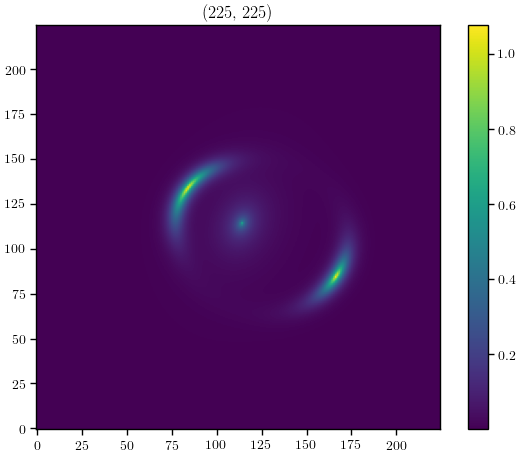

In [3]:
lens = SampleStrongLens()

num_pix = 45
side = 4.95
band = 'F184'
filter_name = band
bandpass = gs.get_bandpass(band)
exposure_time = 146
oversample_factor = 5

# add CDM subhalos
# lens.add_subhalos(util.unpickle(os.path.join(pickle_dir, 'cdm_subhalos_for_sample')))

model = lens.get_array(num_pix=45 * oversample_factor, side=4.95, band=band)
plot.plot(model, colorbar=True, title=model.shape)

In [4]:
# get flux
total_flux_cps = lens.get_total_flux_cps(band)
print(total_flux_cps)

# get interpolated image
interp = InterpolatedImage(Image(model), scale=0.11 / oversample_factor, flux=total_flux_cps * exposure_time)

interp_ref = deepcopy(interp)
interp_worst = deepcopy(interp)
interp_default = deepcopy(interp)
interp_1 = deepcopy(interp)
interp_2 = deepcopy(interp)

326.189283337688


In [7]:
save_dir = os.path.join(data_dir, 'output', 'psfs_for_scenes_across_detectors')
util.create_directory_if_not_exists(save_dir)
kernel_save = os.path.join(save_dir, 'kernels.npy')

if not os.path.exists(kernel_save):
    kernels = []

    # reference position is where the wavefront errors appear to be minimized: SCA04
    reference_pos = (4, 4092)
    psf_reference = psf.get_webbpsf_psf(band, 4, reference_pos, oversample=oversample_factor)

    # where wavefront errors appear to be maximized: SCA17
    worst_pos = (4, 4092)
    psf_worst = psf.get_webbpsf_psf(band, 17, worst_pos, oversample=oversample_factor)

    # include the default position for WebbPSF
    default_pos = (2048, 2048)
    psf_default = psf.get_webbpsf_psf(band, 1, default_pos, oversample=oversample_factor)

    pos_1 = (1024, 3072)
    psf_1 = psf.get_webbpsf_psf(band, 7, pos_1, oversample=oversample_factor)

    pos_2 = (3072, 1024)
    psf_2 = psf.get_webbpsf_psf(band, 15, pos_2, oversample=oversample_factor)

    # pos_3 = (4, 4092)
    # psf_3 = psf.get_webbpsf_psf(band, 11, pos_3, oversample=oversample_factor)

    kernels.append(psf_reference)
    kernels.append(psf_worst)
    kernels.append(psf_default)
    kernels.append(psf_1)
    kernels.append(psf_2)
    # kernels.append(psf_3)

    np.save(kernel_save, kernels)
else:
    print('Loading cached PSF kernels')
    kernels = np.load(kernel_save, allow_pickle=True)
    psf_reference = kernels[0]
    psf_worst = kernels[1]
    psf_default = kernels[2]
    psf_1 = kernels[3]
    psf_2 = kernels[4]
    # psf_3 = kernels[5]

Loading cached PSF kernels


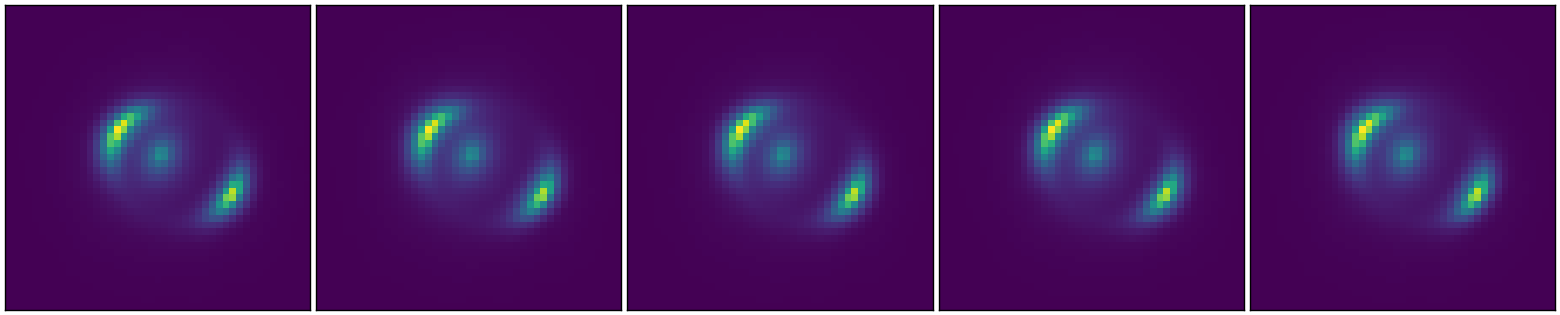

In [8]:
convolved_a = galsim.Convolve(interp_ref, psf_reference)
convolved_b = galsim.Convolve(interp_worst, psf_worst)
convolved_c = galsim.Convolve(interp_default, psf_default)
convolved_d = galsim.Convolve(interp_1, psf_1)
convolved_e = galsim.Convolve(interp_2, psf_2)

# draw interpolated images
im_a = galsim.ImageF(45, 45, scale=0.11)
im_b = galsim.ImageF(45, 45, scale=0.11)
im_c = galsim.ImageF(45, 45, scale=0.11)
im_d = galsim.ImageF(45, 45, scale=0.11)
im_e = galsim.ImageF(45, 45, scale=0.11)

im_a.setOrigin(0, 0)
im_b.setOrigin(0, 0)
im_c.setOrigin(0, 0)
im_d.setOrigin(0, 0)
im_e.setOrigin(0, 0)

image_a = convolved_a.drawImage(im_a).array
image_b = convolved_b.drawImage(im_b).array
image_c = convolved_c.drawImage(im_c).array
image_d = convolved_d.drawImage(im_d).array
image_e = convolved_e.drawImage(im_e).array

# convert to e-/sec from e- total
image_a /= exposure_time
image_b /= exposure_time
image_c /= exposure_time
image_d /= exposure_time
image_e /= exposure_time

plot.plot_list([image_a, image_b, image_c, image_d, image_e])

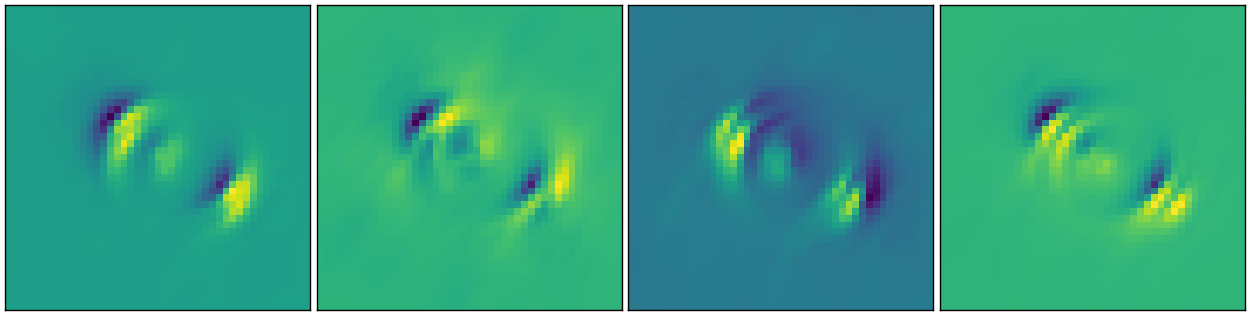

In [9]:
residual_worst = image_a - image_b
residual_default = image_a - image_c
residual_1 = image_a - image_d
residual_2 = image_a - image_e

residual_list = [residual_worst, residual_default, residual_1, residual_2]

plot.plot_list(residual_list)

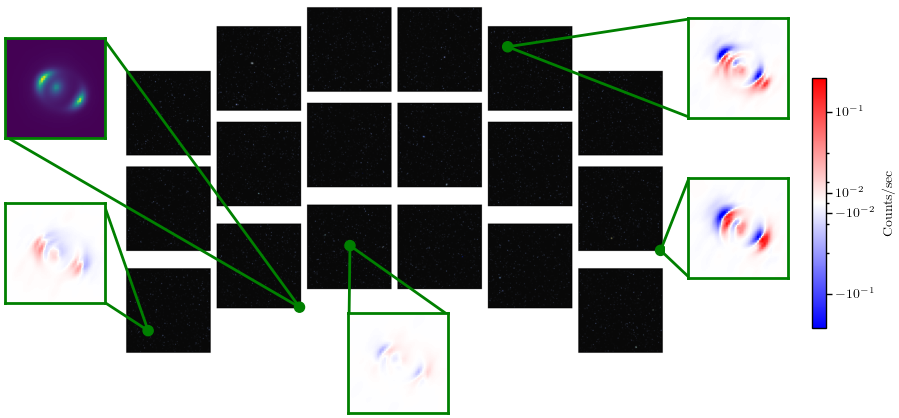

In [15]:
f, ax = plt.subplots(figsize=(7, 5))  # 16, 12

# fontsize = 28
# matplotlib.rcParams.update({'font.size': fontsize})

fov = np.asarray(PIL.Image.open(os.path.join(repo_dir, 'paper', 'graphics', 'hlwas_bkg.png')))
ax.imshow(fov, origin='upper')
ax.set_axis_off()

norm = plot_util.get_norm(residual_list, linear_width=0.1)

box_left = -0.1
box_right = 0.875

marker_color = 'g'
line_color = 'g'

# DEFAULT
image_coords = (901, 954)
circ_image = patches.Circle(image_coords, radius=20, color=marker_color)
_ = ax.add_patch(circ_image)
ax_image = f.add_axes([0.39,0.03,0.2,0.2], anchor='NE', zorder=1)
ax_image.imshow(residual_default, cmap='bwr', norm=norm)
ax_image.spines[:].set_linewidth(2.)
ax_image.spines[:].set_color(line_color)
ax_image.set_xticks([])
ax_image.set_yticks([])
con_image_b = patches.ConnectionPatch(xyA=(0,44), coordsA=ax_image.transData, xyB=image_coords, coordsB=ax.transData, linewidth=2, color=line_color)
con_image_t = patches.ConnectionPatch(xyA=(44,44), coordsA=ax_image.transData, xyB=image_coords, coordsB=ax.transData, linewidth=2, color=line_color)
ax.add_artist(con_image_b)
ax.add_artist(con_image_t)

# 15
worst_coords = (1526, 166)
circ_worst = patches.Circle(worst_coords, radius=20, color=marker_color)
_ = ax.add_patch(circ_worst)
ax_worst = f.add_axes([box_right,0.62,0.2,0.2], anchor='NE', zorder=1)
im = ax_worst.imshow(residual_2, cmap='bwr', norm=norm)
ax_worst.spines[:].set_linewidth(2.)
ax_worst.spines[:].set_color(line_color)
ax_worst.set_xticks([])
ax_worst.set_yticks([])
con_worst_b = patches.ConnectionPatch(xyA=(0,0), coordsA=ax_worst.transData, xyB=worst_coords, coordsB=ax.transData, linewidth=2, color=line_color)
con_worst_t = patches.ConnectionPatch(xyA=(0,44), coordsA=ax_worst.transData, xyB=worst_coords, coordsB=ax.transData, linewidth=2, color=line_color)
ax.add_artist(con_worst_b)
ax.add_artist(con_worst_t)

# REFERENCE (BEST)
circ_default_coords = (101, 1291)
circ_default = patches.Circle(circ_default_coords, radius=20, color=marker_color)
_ = ax.add_patch(circ_default)
ax_default = f.add_axes([box_left,0.25,0.2,0.2], anchor='NE', zorder=1)
ax_default.imshow(residual_1, cmap='bwr', norm=norm)
ax_default.spines[:].set_linewidth(2.)
ax_default.spines[:].set_color(line_color)
ax_default.set_xticks([])
ax_default.set_yticks([])
con_default_b = patches.ConnectionPatch(xyA=(44,0), coordsA=ax_default.transData, xyB=circ_default_coords, coordsB=ax.transData, linewidth=2, color=line_color)
con_default_t = patches.ConnectionPatch(xyA=(44,44), coordsA=ax_default.transData, xyB=circ_default_coords, coordsB=ax.transData, linewidth=2, color=line_color)
ax.add_artist(con_default_b)
ax.add_artist(con_default_t)

# 6
circ_1_coords = (701, 1198)
circ_1 = patches.Circle(circ_1_coords, radius=20, color=marker_color)
_ = ax.add_patch(circ_1)
ax_1 = f.add_axes([box_left,0.58,0.2,0.2], anchor='NE', zorder=1)
ax_1.imshow(image_a, cmap='viridis')  # cividis
ax_1.spines[:].set_linewidth(2.)
ax_1.spines[:].set_color(line_color)
ax_1.set_xticks([])
ax_1.set_yticks([])
con_1_b = patches.ConnectionPatch(xyA=(0,0), coordsA=ax_1.transData, xyB=circ_1_coords, coordsB=ax.transData, linewidth=2, color=line_color)
con_1_t = patches.ConnectionPatch(xyA=(44,44), coordsA=ax_1.transData, xyB=circ_1_coords, coordsB=ax.transData, linewidth=2, color=line_color)
ax.add_artist(con_1_b)
ax.add_artist(con_1_t)

# 17 (WORST)
circ_2_coords = (2132, 973)
circ_2 = patches.Circle(circ_2_coords, radius=20, color=marker_color)
_ = ax.add_patch(circ_2)
ax_2 = f.add_axes([box_right,0.3,0.2,0.2], anchor='NE', zorder=1)
ax_2.imshow(residual_worst, cmap='bwr', norm=norm)
ax_2.spines[:].set_linewidth(2.)
ax_2.spines[:].set_color(line_color)
ax_2.set_xticks([])
ax_2.set_yticks([])
con_2_b = patches.ConnectionPatch(xyA=(0,0), coordsA=ax_2.transData, xyB=circ_2_coords, coordsB=ax.transData, linewidth=2, color=line_color)
con_2_t = patches.ConnectionPatch(xyA=(0,44), coordsA=ax_2.transData, xyB=circ_2_coords, coordsB=ax.transData, linewidth=2, color=line_color)
ax.add_artist(con_2_b)
ax.add_artist(con_2_t)

cax = f.add_axes([box_right + 0.235, 0.2, 0.02, 0.5])
cbar = f.colorbar(im, cax=cax, ticks=[-10 ** -1, -10** -2, 10 ** -2, 10 ** -1])
cbar.set_label('Counts/sec', rotation=90)
# cbar.ax.minorticks_on()

plt.savefig(os.path.join(figure_dir, 'scenes_across_detectors.png'))
plt.show()